Distilling knowledge from a deep NN to a lighter NN and showing how the added weighted loss function from the deeper NN improves the accuracy of the lighter NN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)
train_dataset.data[0].shape

100%|██████████| 170498071/170498071 [00:05<00:00, 29587284.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


(32, 32, 3)

torch.Size([3, 32, 32])
truck


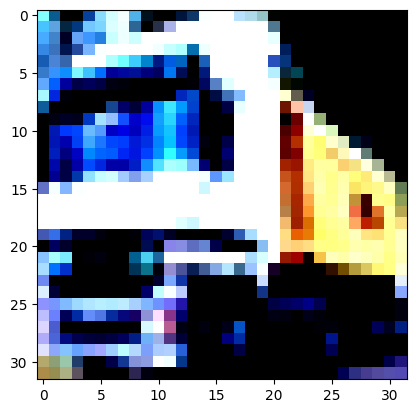

In [3]:
sample, label = train_dataset[1]
print(sample.shape)
print(train_dataset.classes[label])
plt.imshow(sample.transpose(0, 2).transpose(0, 1))

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [5]:
class TeacherNN(nn.Module):
    def __init__(self, num_classes=10):
        super(TeacherNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class StudentNN(nn.Module):
    def __init__(self, num_classes=10):
        super(StudentNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
def train(model,train_loader,epochs,learning_rate,device):
  loss_function = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(),lr=learning_rate)
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
      inputs,labels = inputs.to(device),labels.to(device)
      optimizer.zero_grad()
      output = model(inputs)
      loss = loss_function(output,labels)
      running_loss += loss.item()
      loss.backward()
      optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

def test(model, test_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [7]:
torch.manual_seed(42)
nn_teacher = TeacherNN(num_classes=10).to(device)
train(nn_teacher, train_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_teacher = test(nn_teacher, test_loader, device)

Epoch 1/10, Loss: 1.3351048443018627
Epoch 2/10, Loss: 0.8652533602226725
Epoch 3/10, Loss: 0.6774153832889274
Epoch 4/10, Loss: 0.534406826014409
Epoch 5/10, Loss: 0.41630250962493975
Epoch 6/10, Loss: 0.3150814324617386
Epoch 7/10, Loss: 0.2365481399780954
Epoch 8/10, Loss: 0.1724029124411933
Epoch 9/10, Loss: 0.14350938386357653
Epoch 10/10, Loss: 0.13105618443025652
Test Accuracy: 74.67%


In [9]:
nn_student_no_dist = StudentNN(num_classes=10).to(device)
train(nn_student_no_dist, train_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_student_no_dist = test(nn_student_no_dist, test_loader, device)

Epoch 1/10, Loss: 1.5403955068124835
Epoch 2/10, Loss: 1.207079107346742
Epoch 3/10, Loss: 1.0776958243011514
Epoch 4/10, Loss: 0.9801685442704984
Epoch 5/10, Loss: 0.9004086076146196
Epoch 6/10, Loss: 0.8332757330916422
Epoch 7/10, Loss: 0.7752251204322366
Epoch 8/10, Loss: 0.7197453613628817
Epoch 9/10, Loss: 0.6755900248847044
Epoch 10/10, Loss: 0.6292206643487487
Test Accuracy: 68.99%


In [10]:
torch.manual_seed(42)
nn_student_dist = StudentNN(num_classes=10).to(device)

In [11]:
def train_with_knowledge_dist(student_model, teacher_model, train_loader, epochs, T, learning_rate, soft_target_loss_weight, student_loss_weight, device):
  loss_function = nn.CrossEntropyLoss()
  optimizer = optim.Adam(student_model.parameters(),lr=learning_rate)
  student_model.train()
  teacher_model.eval()
  for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
      inputs,labels = inputs.to(device),labels.to(device)
      optimizer.zero_grad()
      with torch.no_grad():
        teacher_logits = teacher_model(inputs)

      student_logits = student_model(inputs)
      student_loss = loss_function(student_logits,labels)

      soft_teacher = nn.functional.softmax(teacher_logits / T, dim=-1)
      soft_student = nn.functional.log_softmax(student_logits / T, dim=-1)
      soft_targets_loss = -torch.sum(soft_teacher * soft_student) / soft_student.size()[0] * (T**2)

      loss = student_loss*student_loss_weight + soft_targets_loss*soft_target_loss_weight

      running_loss += loss.item()
      loss.backward()
      optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")


In [12]:
train_with_knowledge_dist(nn_student_dist, nn_teacher, train_loader, epochs=10, T=2 , soft_target_loss_weight=0.25,student_loss_weight=0.75, learning_rate=0.001, device=device)
test_accuracy_student_dist = test(nn_student_dist, test_loader, device)

Epoch 1/10, Loss: 2.7075596459381415
Epoch 2/10, Loss: 2.2070359881881556
Epoch 3/10, Loss: 1.9941644003933958
Epoch 4/10, Loss: 1.8329281227667924
Epoch 5/10, Loss: 1.71321067694203
Epoch 6/10, Loss: 1.6093560716380244
Epoch 7/10, Loss: 1.5141683954107181
Epoch 8/10, Loss: 1.4265213220015815
Epoch 9/10, Loss: 1.3481333920412966
Epoch 10/10, Loss: 1.2778168695662029
Test Accuracy: 70.59%
